In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

from sklearn.metrics import make_scorer
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from scipy import stats
from combat.pycombat import pycombat
import umap
from collections import Counter

In [6]:
met_raw_df = pd.read_csv('../data/data_zscore_comp_id.csv')
met_raw_df.set_index(met_raw_df.columns[0], inplace=True)
met_raw_df

,BAYL-08997,BAYL-08998,BAYL-08999,BAYL-09000,BAYL-09001,BAYL-09002,BAYL-09003,BAYL-09004,BAYL-09005,BAYL-09006,...,s_21944,s_22832,s_22842,s_22997,s_23003,s_23077,s_23123,s_22787,s_23294,s_73385
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
42370,-1.259948,0.170557,0.814204,0.038958,-0.504466,-0.757901,-0.986865,0.993000,0.986541,0.000250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,-0.610334,-0.811169,-0.554787,-0.603603,-0.549375,-0.631363,0.606882,1.238204,1.661840,-0.931552,...,-0.434904,-0.730548,-0.009508,-0.607362,0.219333,-0.767359,-0.421440,0.085019,-0.732586,-1.167603
27665,-1.201809,0.387317,-1.062940,0.525122,-0.973446,-0.253533,0.195547,0.769406,0.796718,-0.058625,...,0.825309,2.224161,0.182297,-0.697035,0.161942,-0.266286,0.775185,-0.640354,1.440073,0.458074
38395,-0.954275,-0.906589,4.929942,0.974496,-0.740805,0.642705,-0.293678,0.650630,1.008092,-0.778676,...,-1.505053,-1.112171,0.062801,-0.778621,0.574785,-0.251823,-0.822022,-1.332230,0.767016,-1.741468
437,0.240999,-0.454249,-0.000406,-0.542391,NaN,0.403722,-0.492163,0.252810,-0.517825,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
met_names_df = pd.read_excel('../data/BAYL-04-22MD+ Data Tables Updated.xlsx', sheet_name='Chemical Annotation')
met_names_df = met_names_df.loc[:, ['COMP_ID', 'CHEMICAL_NAME']].sort_values('COMP_ID')  # CHEMICAL_NAME
met_names_df.set_index('COMP_ID', inplace=True)
met_names_df.head()

,CHEMICAL_NAME
COMP_ID,
53,glutamine
54,tryptophan
55,beta-alanine
56,cystine
57,glutamate


In [24]:
clin_df = pd.read_csv('../data/sampleAttr.csv', index_col=0)
# Exclude ASPRE LR
clin_df = clin_df[clin_df['STUDY'] != 'ASPRE_LR']
clin_df

,age,pe,race,consss_batch,ASA_tri_chr,weight,BErm,sle,ga.w,height,ptIDs,Compliance,conception,crl,smoking,STUDY,prev.pe,ASA,trimester
sIDs,,,,,,,,,,,,,,,,,,,
BAYL-08997,36.64887063655031,1.0,Chinese,batch-2023,ASA - 1st Trimester,45.1,batch_2023,0,NaN,150,S1_1_Ca,94.444444,7,55.3,0,CHUK,7,True,1
BAYL-08998,32.309377138945926,1.0,Chinese,batch-2023,ASA - 1st Trimester,82.2,batch_2023,0,NaN,171,S1_2_Ca,94.267516,7,63.1,0,CHUK,2,True,1
BAYL-08999,43.90143737166324,0.0,Chinese,batch-2023,ASA - 1st Trimester,69.6,batch_2023,0,NaN,161,S1_1_Co,99.367089,7,58.8,0,CHUK,7,True,1
BAYL-09000,33.11430527036276,0.0,Chinese,batch-2023,ASA - 1st Trimester,51.4,batch_2023,0,NaN,154,S1_2_Co,98.684211,7,62.9,0,CHUK,7,True,1
BAYL-09001,24.32032854209445,0.0,Chinese,batch-2023,ASA - 1st Trimester,39.2,batch_2023,0,NaN,161,S1_4_Co,95.597484,7,45.3,0,CHUK,7,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,33.8562628336756,0.0,Black,batch-2021,PLACEBO - 2nd Trimester,71.0,batch_2021,No,NaN,162.0,pt_755998,0.000000,Spontaneous,60.2,No,from-2015,Multip-no PE,False,2
s_23123,25.3141683778234,0.0,Black,batch-2021,PLACEBO - 2nd Trimester,58.1,batch_2021,No,NaN,155.0,pt_727062,0.000000,Spontaneous,53.6,No,from-2015,Nullip,False,2
s_22787,29.7659137577002,0.0,Black,batch-2021,PLACEBO - 2nd Trimester,93.8,batch_2021,No,NaN,163.0,pt_20889,0.000000,Spontaneous,59.3,No,from-2015,Multip-no PE,False,2


# Merge and preprocess data

In [30]:
met_raw_df = met_raw_df.loc[:, clin_df.index]  # Take only columns that exist in clinical data
met_raw_df

sIDs,BAYL-08997,BAYL-08998,BAYL-08999,BAYL-09000,BAYL-09001,BAYL-09002,BAYL-09003,BAYL-09004,BAYL-09005,BAYL-09006,...,s_21944,s_22832,s_22842,s_22997,s_23003,s_23077,s_23123,s_22787,s_23294,s_73385
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
42370,-1.259948,0.170557,0.814204,0.038958,-0.504466,-0.757901,-0.986865,0.993000,0.986541,0.000250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
485,-0.610334,-0.811169,-0.554787,-0.603603,-0.549375,-0.631363,0.606882,1.238204,1.661840,-0.931552,...,-0.434904,-0.730548,-0.009508,-0.607362,0.219333,-0.767359,-0.421440,0.085019,-0.732586,-1.167603
27665,-1.201809,0.387317,-1.062940,0.525122,-0.973446,-0.253533,0.195547,0.769406,0.796718,-0.058625,...,0.825309,2.224161,0.182297,-0.697035,0.161942,-0.266286,0.775185,-0.640354,1.440073,0.458074
38395,-0.954275,-0.906589,4.929942,0.974496,-0.740805,0.642705,-0.293678,0.650630,1.008092,-0.778676,...,-1.505053,-1.112171,0.062801,-0.778621,0.574785,-0.251823,-0.822022,-1.332230,0.767016,-1.741468
437,0.240999,-0.454249,-0.000406,-0.542391,NaN,0.403722,-0.492163,0.252810,-0.517825,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
met_df = met_raw_df.merge(met_names_df, left_index=True, right_index=True)
met_df.set_index('CHEMICAL_NAME', inplace=True)
met_df = met_df.T
# met_df.loc[:, 'pe'] = clin_df['pe']
# met_df = met_df[clin_df['trimester'] == 3]
print(f'Initial number of metabolites: {met_df.shape[1]}')
met_df = met_df.loc[:, met_df.isnull().sum() < 0.2*met_df.shape[0]]  # Fill rate > 80%
print(f'Number of metabolites after Fill rate > 80% filter: {met_df.shape[1]}')
met_df = met_df[list(filter(lambda x: 'x' not in x.lower(), met_df.columns))]
print(f'Number of metabolites after removing X-molecules: {met_df.shape[1]}')
met_df = met_df.fillna(met_df.min())
met_df

Initial number of metabolites: 968
Number of metabolites after Fill rate > 80% filter: 736
Number of metabolites after removing X-molecules: 525


CHEMICAL_NAME,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-phosphoglycerate,cholate,"5,6-dihydrothymine","9,10-DiHOME",linoleate (18:2n6),...,glycine conjugate of C10H14O2 (1)*,"sphingomyelin (d17:1/14:0, d16:1/15:0)*",6-bromotryptophan,dodecadienoate (12:2)*,N-acetyl-isoputreanine,glucuronide of piperine metabolite C17H21NO3 (4)*,sulfate of piperine metabolite C16H19NO3 (2)*,sulfate of piperine metabolite C16H19NO3 (3)*,sulfate of piperine metabolite C18H21NO3 (1)*,sulfate of piperine metabolite C18H21NO3 (3)*
BAYL-08997,-0.610334,-1.201809,-0.954275,-0.485987,0.598959,-0.660514,-0.355321,-0.898309,-0.667690,-0.874199,...,-0.939114,-0.838303,-1.399022,-0.656606,-1.702764,-0.667845,-0.884692,-0.810793,-0.770932,-0.683563
BAYL-08998,-0.811169,0.387317,-0.906589,-0.409053,0.612680,0.001887,-0.108802,-0.111114,-0.696468,-0.820280,...,-0.396659,-0.697519,0.887825,-1.112439,-0.969079,-1.029021,-0.466641,-0.426476,-0.438533,-0.397876
BAYL-08999,-0.554787,-1.062940,4.929942,0.022588,3.050217,-0.142467,-0.215959,-0.479178,2.368797,1.660334,...,0.851302,-0.742232,-0.390750,0.301971,-0.991800,0.009966,-0.514876,-0.396405,-0.244924,0.445289
BAYL-09000,-0.603603,0.525122,0.974496,-0.494779,-0.347355,-0.359097,-0.335079,-0.369941,0.309919,-0.618017,...,-0.487078,-0.952760,1.479042,-0.445710,-0.805737,-0.751043,-0.781056,-0.756450,-0.922030,-0.847816
BAYL-09001,-0.549375,-0.973446,-0.740805,-0.049422,-0.787278,-0.515097,-0.176998,4.681018,-0.627905,0.940678,...,1.260862,-0.534981,0.603498,1.521883,-0.866545,-0.341395,0.272540,0.212023,-0.165409,0.366029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-0.767359,-0.266286,-0.251823,0.162015,-2.564631,-0.809305,-0.028283,-0.336513,-0.733505,-1.243590,...,-0.756449,1.115718,-1.628595,-3.419015,-0.335398,-0.141188,1.051963,0.962210,1.060235,0.956444
s_23123,-0.421440,0.775185,-0.822022,-0.091252,-1.624241,-0.779540,-0.168885,-1.447742,-0.977625,-1.101853,...,-1.007543,0.400393,-1.121863,-1.153469,-0.352297,-0.400432,0.283153,0.157192,0.443618,0.300457
s_22787,0.085019,-0.640354,-1.332230,0.534896,-2.285493,-0.649324,0.127443,-0.342412,-2.082006,-1.367824,...,-0.008867,-0.175965,-1.298844,-2.070522,0.141490,-0.437914,0.469147,0.512265,0.648034,0.539695
s_23294,-0.732586,1.440073,0.767016,-0.599035,-1.277730,-1.076107,-2.074105,-0.264915,1.019940,-0.965180,...,-1.569176,1.376506,0.067642,-1.343205,-0.396227,1.330839,1.435338,1.397590,1.336402,1.233001


# Remove batch effects

In [32]:
clin_df.loc[:, 'STUDY'] = clin_df.loc[:, 'STUDY'].apply(lambda x: x.replace('from-2015', 'previous study'))
batches = list(clin_df['STUDY'].unique())
batches_dict = {k: v for v, k in enumerate(batches)}
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(met_df)

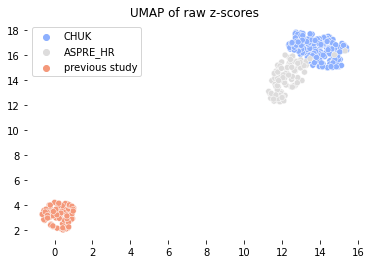

In [33]:
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=clin_df['STUDY'].apply(lambda x: batches[batches_dict[x]]).values, palette='coolwarm')
plt.title('UMAP of raw z-scores')
plt.box(False)
# plt.savefig('umap_before_batch.png', dpi=250, bbox_inches='tight')
plt.show()

In [34]:
met_df_corrected = pycombat(met_df.T, clin_df['STUDY'].values).T

Found 3 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


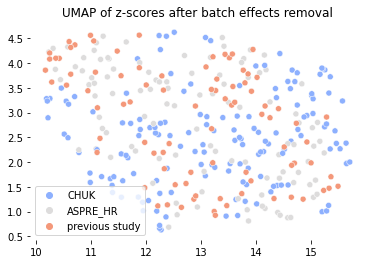

In [36]:
umap_result_corrected = umap_model.fit_transform(met_df_corrected)
sns.scatterplot(x=umap_result_corrected[:, 0], y=umap_result_corrected[:, 1], hue=clin_df['STUDY'].apply(lambda x: batches[batches_dict[x]]).values, palette='coolwarm')
plt.title('UMAP of z-scores after batch effects removal')
plt.box(False)
plt.savefig('umap_after_batch.png', dpi=250)
plt.show()
plt.show()

In [38]:
outliers = set()  #set(clin_df.iloc[umap_result_corrected[:, 0] < 8.5, :].index)  # Check UMAP then set threshold
met_df_corr_filt = met_df_corrected[~met_df_corrected.index.isin(outliers)].copy()
met_df_corr_filt.loc[:, 'pe'] = clin_df['pe']
clin_filt_df = clin_df[~clin_df.index.isin(outliers)]
met_df_corr_filt.shape

(344, 526)

In [39]:
met_df_corr_filt

CHEMICAL_NAME,spermidine,1-methylnicotinamide,"12,13-DiHOME",alpha-ketoglutarate,kynurenate,3-phosphoglycerate,cholate,"5,6-dihydrothymine","9,10-DiHOME",linoleate (18:2n6),...,"sphingomyelin (d17:1/14:0, d16:1/15:0)*",6-bromotryptophan,dodecadienoate (12:2)*,N-acetyl-isoputreanine,glucuronide of piperine metabolite C17H21NO3 (4)*,sulfate of piperine metabolite C16H19NO3 (2)*,sulfate of piperine metabolite C16H19NO3 (3)*,sulfate of piperine metabolite C18H21NO3 (1)*,sulfate of piperine metabolite C18H21NO3 (3)*,pe
BAYL-08997,-0.286571,-0.815834,-0.870362,-0.214411,0.177038,-0.390501,-0.335638,-0.888478,-0.850481,-0.896163,...,-0.280552,-1.425292,-0.959272,-1.473403,-0.524333,-0.721080,-0.663478,-0.673977,-0.506003,1.0
BAYL-08998,-0.602523,0.685851,-0.835227,-0.071667,0.187460,0.649138,0.109823,-0.139081,-0.880518,-0.843660,...,-0.127382,0.691267,-1.395096,-0.714445,-0.856199,-0.215846,-0.186106,-0.241607,-0.175867,1.0
BAYL-08999,-0.199185,-0.684607,3.465233,0.729203,2.038830,0.422575,-0.083810,-0.489472,2.318804,1.571811,...,-0.176029,-0.492101,-0.042775,-0.737948,0.098474,-0.274140,-0.148754,0.010231,0.798479,0.0
BAYL-09000,-0.275981,0.816073,0.550790,-0.230724,-0.541711,0.082574,-0.299062,-0.385480,0.169883,-0.646709,...,-0.405079,1.238460,-0.757635,-0.545475,-0.600779,-0.595831,-0.595977,-0.870518,-0.695810,0.0
BAYL-09001,-0.190670,-0.600036,-0.713074,0.595595,-0.875843,-0.162268,-0.013408,4.422950,-0.808956,0.871054,...,0.049455,0.428112,1.123586,-0.608379,-0.224374,0.677488,0.606995,0.113661,0.706888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.104168,-0.737232,0.354517,0.051595,-1.610757,-0.909409,-0.153698,-0.033276,-0.282290,-0.719215,...,0.313715,-1.222637,-1.788862,0.144833,-0.670509,0.428230,0.410241,0.484324,0.349684,0.0
s_23123,-0.426422,0.242386,-0.705730,-0.271371,-0.703841,-0.857799,-0.245339,-1.493998,-0.537797,-0.569394,...,-0.215925,-0.638400,-0.141950,0.124281,-0.923275,-0.303200,-0.402520,-0.099562,-0.215420,0.0
s_22787,0.565867,-1.089084,-1.654426,0.527096,-1.341556,-0.632016,-0.052199,-0.041030,-1.693692,-0.850535,...,-0.642672,-0.842450,-0.808591,0.724791,-0.959821,-0.126248,-0.044032,0.094003,-0.009327,0.0
s_23294,-1.036038,0.867787,2.248981,-0.918900,-0.369665,-1.372020,-1.487119,0.060840,1.552945,-0.424926,...,0.506808,0.733041,-0.279877,0.070856,0.764732,0.792966,0.849809,0.745832,0.587926,0.0


In [42]:
# Read again metabolite names now with Chemical name
met_names_df = pd.read_excel('../data/BAYL-04-22MD+ Data Tables Updated.xlsx', sheet_name='Chemical Annotation')
met_names_df = met_names_df.loc[:, ['CHEMICAL_NAME', 'CHEM_ID']]
met_names_dict = {x[0]: x[1] for x in met_names_df.values}
met_names_dict['pe'] = 'pe'
met_names_df.set_index('CHEMICAL_NAME', inplace=True)
met_names_df.head()


met_df_corr_filt.columns = [met_names_dict[x] for x in met_df_corr_filt.columns]
met_df_corr_filt

,50,55,62,93,98,132,136,158,179,180,...,100020276,100020414,100020478,100020487,100020492,100020496,100020497,100020502,100020504,pe
BAYL-08997,-0.286571,-0.815834,-0.870362,-0.214411,0.177038,-0.390501,-0.335638,-0.888478,-0.850481,-0.896163,...,-0.280552,-1.425292,-0.959272,-1.473403,-0.524333,-0.721080,-0.663478,-0.673977,-0.506003,1.0
BAYL-08998,-0.602523,0.685851,-0.835227,-0.071667,0.187460,0.649138,0.109823,-0.139081,-0.880518,-0.843660,...,-0.127382,0.691267,-1.395096,-0.714445,-0.856199,-0.215846,-0.186106,-0.241607,-0.175867,1.0
BAYL-08999,-0.199185,-0.684607,3.465233,0.729203,2.038830,0.422575,-0.083810,-0.489472,2.318804,1.571811,...,-0.176029,-0.492101,-0.042775,-0.737948,0.098474,-0.274140,-0.148754,0.010231,0.798479,0.0
BAYL-09000,-0.275981,0.816073,0.550790,-0.230724,-0.541711,0.082574,-0.299062,-0.385480,0.169883,-0.646709,...,-0.405079,1.238460,-0.757635,-0.545475,-0.600779,-0.595831,-0.595977,-0.870518,-0.695810,0.0
BAYL-09001,-0.190670,-0.600036,-0.713074,0.595595,-0.875843,-0.162268,-0.013408,4.422950,-0.808956,0.871054,...,0.049455,0.428112,1.123586,-0.608379,-0.224374,0.677488,0.606995,0.113661,0.706888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.104168,-0.737232,0.354517,0.051595,-1.610757,-0.909409,-0.153698,-0.033276,-0.282290,-0.719215,...,0.313715,-1.222637,-1.788862,0.144833,-0.670509,0.428230,0.410241,0.484324,0.349684,0.0
s_23123,-0.426422,0.242386,-0.705730,-0.271371,-0.703841,-0.857799,-0.245339,-1.493998,-0.537797,-0.569394,...,-0.215925,-0.638400,-0.141950,0.124281,-0.923275,-0.303200,-0.402520,-0.099562,-0.215420,0.0
s_22787,0.565867,-1.089084,-1.654426,0.527096,-1.341556,-0.632016,-0.052199,-0.041030,-1.693692,-0.850535,...,-0.642672,-0.842450,-0.808591,0.724791,-0.959821,-0.126248,-0.044032,0.094003,-0.009327,0.0
s_23294,-1.036038,0.867787,2.248981,-0.918900,-0.369665,-1.372020,-1.487119,0.060840,1.552945,-0.424926,...,0.506808,0.733041,-0.279877,0.070856,0.764732,0.792966,0.849809,0.745832,0.587926,0.0


# Split and train

In [43]:
clin_subset_df = clin_filt_df.loc[met_df_corr_filt.index, :]  # Exclude this line if no risks should be considered                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     `.    

for trimester in [{1}, {2}, {3}, {1, 2, 3}]:  #, 
    trimester_str = '_'.join([str(x) for x in trimester])
    met_subset_df = met_df_corr_filt[clin_subset_df['trimester'].isin(trimester)]
     
    # Uncomment if random train/test split is desired
    train_set, test_set = train_test_split(met_subset_df, test_size=0.2, shuffle=True,  random_state=42, stratify=met_subset_df['pe'])
    
    
    X_train = pd.DataFrame(train_set.copy(), columns=met_subset_df.columns)
    X_train = X_train.drop("pe", axis=1)
    y_train = train_set["pe"].copy()

    X_test = pd.DataFrame(test_set.copy(), columns=met_subset_df.columns)
    X_test = X_test.drop("pe", axis=1) 
    y_test = test_set["pe"].copy()

    out_df = pd.DataFrame(columns=['feature selection method', 'number of selected features', 'precision', 'recall', 
                                   'f1_score', 'roc_auc', 'sensitivity', 'specificity', 'AUC train CV'])
    cnt = 0
    gini_importances = []

    pred_type_dict = {f_classif: 'ANOVA F-value between label/feature',
                     mutual_info_classif: 'Mutual information'}
#                      None: 'pyrmr'}  # , chi2 does not work with negative, and we have z-scores 
    


    for pred_type in pred_type_dict:
        print('---------', pred_type_dict[pred_type], f'Trimester {trimester_str}')

        xg_class = xgboost.XGBClassifier(n_estimators=2000, max_depth=10)#, learning_rate=0.2, subsample=1, 
                                         #colsample_bytree=1, eval_metric='logloss',
                                        #use_label_encoder=False)


        # Try different values for k_best
        for k_best in [10, 20, 50, 100, 200, 300]: 

            selector_final = SelectKBest(pred_type, k=k_best)

            X_train_best = selector_final.fit_transform(X_train, y_train)
            features_final = selector_final.get_support(indices=True)
            new_features = X_train.columns[features_final]

            X_train_best = pd.DataFrame(X_train_best, columns=new_features)
            X_train_best.index = train_set.index

            # gene_level_data_kbest.columns = new_features
            X_test_best = X_test[new_features]
            X_test_best.index = test_set.index

            # Add clinical
            #X_train_best.index = X_train_best.index.map(lambda x: x.rstrip('_' + ds.upper()))
            #X_test_best.index = X_test_best.index.map(lambda x: x.rstrip('_' + ds.upper()))

            ion_columns = X_train_best.columns

            # Fit the model
            xg_class.fit(X_train_best, y_train)
            

            # Lets see top importances
            feats = {} # a dict to hold feature_name: feature_importance
            for feature, importance in zip(X_train_best.columns, xg_class.feature_importances_):
                feats[feature] = importance #add the name/value pair 

            importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
            top_importances = importances.sort_values(by='Gini-importance', ascending=False)
            gini_importances.append(top_importances)

            k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

            # Perform cross-validation with AUC scoring
            cv_scores = cross_val_score(xg_class, X_train_best, y_train, cv=k_fold, scoring='roc_auc')


            # xgb classifier error
            # Sensitivity (recall(1) and Specificity recall(0)
            def sens_spec(*args):
                rep = metrics.recall_score(*args, average=None, zero_division=0)
                return float(rep[0] + rep[1]) / 2.

            pred_xgb = xg_class.predict(X_test_best)
            scores_dict = dict()
            scores_dict['precision'] = precision_score(y_test, pred_xgb)
            scores_dict['recall'] = recall_score(y_test, pred_xgb)
            scores_dict['f1_score'] = f1_score(y_test, pred_xgb)
            scores_dict['conf_mat'] = confusion_matrix(y_test, pred_xgb)
            scores_dict['roc_auc'] = roc_auc_score(y_test, pred_xgb)
            scores_dict['sensitivity'], scores_dict['specificity'] = recall_score(y_test, pred_xgb, average=None, zero_division=0)
            scores_dict['train_cv_auc'] = np.mean(cv_scores)
            out_df.loc[cnt, :] = [pred_type_dict[pred_type], k_best, scores_dict['precision'], scores_dict['recall'],
                                 scores_dict['f1_score'], scores_dict['roc_auc'], scores_dict['sensitivity'],
                                  scores_dict['specificity'], scores_dict['train_cv_auc']]
            cnt += 1


        print(f'{len(X_train)} train and {len(X_test)} test samples in {trimester_str}.')

    out_df = out_df.sort_values(by='roc_auc', ascending=False)
    out_df.reset_index(drop=True, inplace=True)
    out_df.to_csv(f'prediction_scores_trimester_{trimester}_no_LR_samples.csv', index=False)
    gini_importances[out_df.index[0]].to_csv('gini_importances_{}_no_LR_samples.csv'.format(trimester_str))
    display(out_df)
    display(gini_importances[out_df.index[0]][:10])

--------- ANOVA F-value between label/feature Trimester 1
68 train and 17 test samples in 1.
--------- Mutual information Trimester 1
68 train and 17 test samples in 1.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,ANOVA F-value between label/feature,50,0.75,0.666667,0.705882,0.708333,0.75,0.666667,0.61381
1,ANOVA F-value between label/feature,20,0.666667,0.666667,0.666667,0.645833,0.625,0.666667,0.673333
2,Mutual information,50,0.666667,0.666667,0.666667,0.645833,0.625,0.666667,0.562857
3,Mutual information,300,0.666667,0.666667,0.666667,0.645833,0.625,0.666667,0.648214
4,Mutual information,10,0.666667,0.444444,0.533333,0.597222,0.75,0.444444,0.623452
5,Mutual information,100,0.6,0.666667,0.631579,0.583333,0.5,0.666667,0.602143
6,ANOVA F-value between label/feature,200,0.571429,0.444444,0.5,0.534722,0.625,0.444444,0.585952
7,ANOVA F-value between label/feature,300,0.555556,0.555556,0.555556,0.527778,0.5,0.555556,0.589167
8,Mutual information,20,0.555556,0.555556,0.555556,0.527778,0.5,0.555556,0.65881
9,ANOVA F-value between label/feature,10,0.5,0.444444,0.470588,0.472222,0.5,0.444444,0.613452


,Gini-importance
100001567,0.351746
100002028,0.151862
100001383,0.133610
100001570,0.113347
100005350,0.099856
100000007,0.084149
100001263,0.027751
100001569,0.027712
100008984,0.005750
100001511,0.004217


--------- ANOVA F-value between label/feature Trimester 2
84 train and 22 test samples in 2.
--------- Mutual information Trimester 2
84 train and 22 test samples in 2.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,ANOVA F-value between label/feature,20,0.583333,0.583333,0.583333,0.541667,0.5,0.583333,0.775159
1,Mutual information,200,0.571429,0.666667,0.615385,0.533333,0.4,0.666667,0.511905
2,ANOVA F-value between label/feature,300,0.5,0.416667,0.454545,0.458333,0.5,0.416667,0.632857
3,Mutual information,100,0.5,0.5,0.5,0.45,0.4,0.5,0.568175
4,ANOVA F-value between label/feature,200,0.5,0.583333,0.538462,0.441667,0.3,0.583333,0.612143
5,Mutual information,10,0.5,0.583333,0.538462,0.441667,0.3,0.583333,0.596111
6,Mutual information,20,0.5,0.583333,0.538462,0.441667,0.3,0.583333,0.712857
7,Mutual information,50,0.466667,0.583333,0.518519,0.391667,0.2,0.583333,0.650079
8,ANOVA F-value between label/feature,50,0.416667,0.416667,0.416667,0.358333,0.3,0.416667,0.732857
9,ANOVA F-value between label/feature,100,0.416667,0.416667,0.416667,0.358333,0.3,0.416667,0.695079


,Gini-importance
356,0.203496
100020276,0.190638
100001550,0.175385
100016019,0.136762
100015792,0.072172
100002152,0.055264
100009035,0.054912
100009037,0.046958
100001755,0.042588
1235,0.021825


--------- ANOVA F-value between label/feature Trimester 3
122 train and 31 test samples in 3.
--------- Mutual information Trimester 3
122 train and 31 test samples in 3.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,ANOVA F-value between label/feature,10,0.666667,0.8,0.727273,0.7125,0.625,0.8,0.696926
1,Mutual information,300,0.666667,0.8,0.727273,0.7125,0.625,0.8,0.61404
2,ANOVA F-value between label/feature,20,0.6875,0.733333,0.709677,0.710417,0.6875,0.733333,0.692897
3,Mutual information,50,0.714286,0.666667,0.689655,0.708333,0.75,0.666667,0.657714
4,ANOVA F-value between label/feature,50,0.647059,0.733333,0.6875,0.679167,0.625,0.733333,0.745967
5,Mutual information,20,0.777778,0.466667,0.583333,0.670833,0.875,0.466667,0.598308
6,ANOVA F-value between label/feature,200,0.611111,0.733333,0.666667,0.647917,0.5625,0.733333,0.674502
7,ANOVA F-value between label/feature,100,0.625,0.666667,0.645161,0.645833,0.625,0.666667,0.74131
8,Mutual information,100,0.625,0.666667,0.645161,0.645833,0.625,0.666667,0.670277
9,Mutual information,200,0.578947,0.733333,0.647059,0.616667,0.5,0.733333,0.655369


,Gini-importance
1254,0.270758
100001256,0.156492
1268,0.123781
100009215,0.081362
100000491,0.074730
100006379,0.074577
1134,0.062050
100001597,0.058789
1526,0.049035
100001126,0.048425


--------- ANOVA F-value between label/feature Trimester 1_2_3
275 train and 69 test samples in 1_2_3.
--------- Mutual information Trimester 1_2_3
275 train and 69 test samples in 1_2_3.


,feature selection method,number of selected features,precision,recall,f1_score,roc_auc,sensitivity,specificity,AUC train CV
0,ANOVA F-value between label/feature,20,0.647059,0.628571,0.637681,0.637815,0.647059,0.628571,0.709457
1,Mutual information,50,0.645161,0.571429,0.606061,0.62395,0.676471,0.571429,0.666102
2,ANOVA F-value between label/feature,50,0.628571,0.628571,0.628571,0.623109,0.617647,0.628571,0.690568
3,ANOVA F-value between label/feature,100,0.615385,0.685714,0.648649,0.622269,0.558824,0.685714,0.676474
4,ANOVA F-value between label/feature,10,0.625,0.571429,0.597015,0.609244,0.647059,0.571429,0.718998
5,Mutual information,300,0.617647,0.6,0.608696,0.608824,0.617647,0.6,0.685515
6,Mutual information,100,0.62963,0.485714,0.548387,0.595798,0.705882,0.485714,0.704602
7,ANOVA F-value between label/feature,300,0.612903,0.542857,0.575758,0.594958,0.647059,0.542857,0.647871
8,Mutual information,20,0.588235,0.571429,0.57971,0.579832,0.588235,0.571429,0.667114
9,ANOVA F-value between label/feature,200,0.548387,0.485714,0.515152,0.536975,0.588235,0.485714,0.664564


,Gini-importance
100001359,0.147800
356,0.144886
100001126,0.131384
100008984,0.105404
1134,0.092840
100001992,0.086410
100009009,0.084860
100002152,0.078899
100002017,0.077765
100009215,0.049751


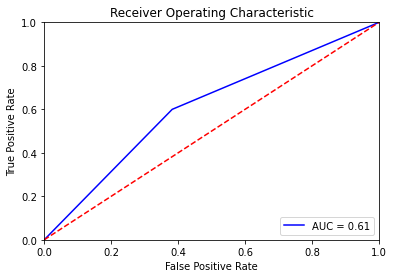

In [44]:
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_xgb)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Univariate analysis PE/No PE

In [45]:
met_chem_df = met_df_corr_filt.copy()  #met_chem_df.T
met_chem_df.loc[:, 'pe'] = clin_filt_df['pe']
print(len(clin_filt_df), len(met_chem_df))
met_chem_df

344 344


,50,55,62,93,98,132,136,158,179,180,...,100020276,100020414,100020478,100020487,100020492,100020496,100020497,100020502,100020504,pe
BAYL-08997,-0.286571,-0.815834,-0.870362,-0.214411,0.177038,-0.390501,-0.335638,-0.888478,-0.850481,-0.896163,...,-0.280552,-1.425292,-0.959272,-1.473403,-0.524333,-0.721080,-0.663478,-0.673977,-0.506003,1.0
BAYL-08998,-0.602523,0.685851,-0.835227,-0.071667,0.187460,0.649138,0.109823,-0.139081,-0.880518,-0.843660,...,-0.127382,0.691267,-1.395096,-0.714445,-0.856199,-0.215846,-0.186106,-0.241607,-0.175867,1.0
BAYL-08999,-0.199185,-0.684607,3.465233,0.729203,2.038830,0.422575,-0.083810,-0.489472,2.318804,1.571811,...,-0.176029,-0.492101,-0.042775,-0.737948,0.098474,-0.274140,-0.148754,0.010231,0.798479,0.0
BAYL-09000,-0.275981,0.816073,0.550790,-0.230724,-0.541711,0.082574,-0.299062,-0.385480,0.169883,-0.646709,...,-0.405079,1.238460,-0.757635,-0.545475,-0.600779,-0.595831,-0.595977,-0.870518,-0.695810,0.0
BAYL-09001,-0.190670,-0.600036,-0.713074,0.595595,-0.875843,-0.162268,-0.013408,4.422950,-0.808956,0.871054,...,0.049455,0.428112,1.123586,-0.608379,-0.224374,0.677488,0.606995,0.113661,0.706888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.104168,-0.737232,0.354517,0.051595,-1.610757,-0.909409,-0.153698,-0.033276,-0.282290,-0.719215,...,0.313715,-1.222637,-1.788862,0.144833,-0.670509,0.428230,0.410241,0.484324,0.349684,0.0
s_23123,-0.426422,0.242386,-0.705730,-0.271371,-0.703841,-0.857799,-0.245339,-1.493998,-0.537797,-0.569394,...,-0.215925,-0.638400,-0.141950,0.124281,-0.923275,-0.303200,-0.402520,-0.099562,-0.215420,0.0
s_22787,0.565867,-1.089084,-1.654426,0.527096,-1.341556,-0.632016,-0.052199,-0.041030,-1.693692,-0.850535,...,-0.642672,-0.842450,-0.808591,0.724791,-0.959821,-0.126248,-0.044032,0.094003,-0.009327,0.0
s_23294,-1.036038,0.867787,2.248981,-0.918900,-0.369665,-1.372020,-1.487119,0.060840,1.552945,-0.424926,...,0.506808,0.733041,-0.279877,0.070856,0.764732,0.792966,0.849809,0.745832,0.587926,0.0


In [46]:
import scipy.stats as stats
subsets = [{1}, {2}, {3}, {1,2,3}]


# Univariate analysis with aspirin: PE vs no-PE
with pd.ExcelWriter("ttests_NO_LR.xlsx") as writer:
    for sub in subsets:
        uni_df = met_chem_df.copy()
        uni_df.loc[:, 'ASA'] = clin_filt_df['ASA']
        uni_df = uni_df.loc[clin_filt_df['trimester'].isin(sub), :]
        uni_df = uni_df.loc[uni_df['ASA'] == True, uni_df.columns != 'ASA']
        print(f'Number of samples in {sub} trimester: {len(uni_df)}')
        tstats_df = pd.DataFrame(columns=['Metabolite', 't-statistic', '-log(p-value)', 'delta-z (mean(PE) - mean(NO_PE))', 'mean(NO_PE)', 'mean(PE)', 'p-value', 'p-value-adj', '-log(p-value-adj)']) 
        # Perform the t-test for each column in your DataFrame
        for ind, col in enumerate(uni_df.columns[:-1]):
            dist_no_pe = uni_df.loc[uni_df['pe']==0., col]
            dist_pe = uni_df.loc[uni_df['pe']!=0., col]
            t_stat, p_value = stats.ttest_ind(dist_pe, dist_no_pe)
#             if p_value < 0.05:
            tstats_df.loc[ind, :] = [col, t_stat, -np.log(p_value), dist_pe.mean() - dist_no_pe.mean(), dist_no_pe.mean(), dist_pe.mean(), p_value, p_value * len(uni_df.columns), -np.log(p_value * len(uni_df.columns))]
        tstats_df.sort_values(by='-log(p-value)', inplace=True, ascending=False)
        tstats_df.to_excel(writer, sheet_name=''.join(map(str, sub)) + '_trimester', index=False)


Number of samples in {1} trimester: 52
Number of samples in {2} trimester: 52
Number of samples in {3} trimester: 47
Number of samples in {1, 2, 3} trimester: 151


In [47]:
# Univariate analysis with no aspirin: PE vs no-PE

subsets = [{1}, {2}, {3}, {1,2,3}]

with pd.ExcelWriter("ttests_no_asp_no_LR.xlsx") as writer:
    for sub in subsets:
        uni_no_asp = met_chem_df.copy()
        uni_no_asp.loc[:, 'pe'] = clin_df['pe']
        uni_no_asp = uni_no_asp[(clin_df['trimester'].isin(sub)) & (clin_df['ASA'] == False)]
        
#         uni_df = uni_df.loc[uni_df['ASA'] == True, uni_df.columns != 'ASA']
        print(f'Number of samples in {sub} trimester: {len(uni_no_asp)}')
        tstats_df = pd.DataFrame(columns=['Metabolite', 't-statistic', '-log(p-value)', 'delta-z (mean(PE) - mean(NO_PE))', 'mean(NO_PE)', 'mean(PE)']) 
        # Perform the t-test for each column in your DataFrame
        for ind, col in enumerate(uni_no_asp.columns[:-1]):
            dist_no_pe = uni_no_asp.loc[uni_no_asp['pe']==0., col]
            dist_pe = uni_no_asp.loc[uni_no_asp['pe']!=0., col]
            t_stat, p_value = stats.ttest_ind(dist_pe, dist_no_pe)
            if p_value < 0.05:
                tstats_df.loc[ind, :] = [col, t_stat, -np.log(p_value), dist_pe.mean() - dist_no_pe.mean(), dist_no_pe.mean(), dist_pe.mean()]
        tstats_df.sort_values(by='-log(p-value)', inplace=True, ascending=False)
        tstats_df.to_excel(writer, sheet_name=''.join(map(str, sub)) + '_trimester', index=False)


Number of samples in {1} trimester: 33
Number of samples in {2} trimester: 54
Number of samples in {3} trimester: 106
Number of samples in {1, 2, 3} trimester: 193


# Diff aspirin vs. placebo

In [48]:
met_asp_df = met_df_corr_filt.copy()
met_asp_df = met_asp_df.loc[:, met_asp_df.columns != 'pe']
met_asp_df

,50,55,62,93,98,132,136,158,179,180,...,100020254,100020276,100020414,100020478,100020487,100020492,100020496,100020497,100020502,100020504
BAYL-08997,-0.286571,-0.815834,-0.870362,-0.214411,0.177038,-0.390501,-0.335638,-0.888478,-0.850481,-0.896163,...,-1.034967,-0.280552,-1.425292,-0.959272,-1.473403,-0.524333,-0.721080,-0.663478,-0.673977,-0.506003
BAYL-08998,-0.602523,0.685851,-0.835227,-0.071667,0.187460,0.649138,0.109823,-0.139081,-0.880518,-0.843660,...,-0.463364,-0.127382,0.691267,-1.395096,-0.714445,-0.856199,-0.215846,-0.186106,-0.241607,-0.175867
BAYL-08999,-0.199185,-0.684607,3.465233,0.729203,2.038830,0.422575,-0.083810,-0.489472,2.318804,1.571811,...,0.851655,-0.176029,-0.492101,-0.042775,-0.737948,0.098474,-0.274140,-0.148754,0.010231,0.798479
BAYL-09000,-0.275981,0.816073,0.550790,-0.230724,-0.541711,0.082574,-0.299062,-0.385480,0.169883,-0.646709,...,-0.558642,-0.405079,1.238460,-0.757635,-0.545475,-0.600779,-0.595831,-0.595977,-0.870518,-0.695810
BAYL-09001,-0.190670,-0.600036,-0.713074,0.595595,-0.875843,-0.162268,-0.013408,4.422950,-0.808956,0.871054,...,1.283223,0.049455,0.428112,1.123586,-0.608379,-0.224374,0.677488,0.606995,0.113661,0.706888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.104168,-0.737232,0.354517,0.051595,-1.610757,-0.909409,-0.153698,-0.033276,-0.282290,-0.719215,...,-0.203571,0.313715,-1.222637,-1.788862,0.144833,-0.670509,0.428230,0.410241,0.484324,0.349684
s_23123,-0.426422,0.242386,-0.705730,-0.271371,-0.703841,-0.857799,-0.245339,-1.493998,-0.537797,-0.569394,...,-0.449647,-0.215925,-0.638400,-0.141950,0.124281,-0.923275,-0.303200,-0.402520,-0.099562,-0.215420
s_22787,0.565867,-1.089084,-1.654426,0.527096,-1.341556,-0.632016,-0.052199,-0.041030,-1.693692,-0.850535,...,0.529067,-0.642672,-0.842450,-0.808591,0.724791,-0.959821,-0.126248,-0.044032,0.094003,-0.009327
s_23294,-1.036038,0.867787,2.248981,-0.918900,-0.369665,-1.372020,-1.487119,0.060840,1.552945,-0.424926,...,-1.000053,0.506808,0.733041,-0.279877,0.070856,0.764732,0.792966,0.849809,0.745832,0.587926


In [49]:
subsets = [{1}, {2}, {3}, {1,2,3}]
# Univariate analysis placebo vs. aspirin
with pd.ExcelWriter("ttests_aspirin_vs_placebo_no_LR.xlsx") as writer:
    for sub in subsets:
        uni_df = met_asp_df.copy()
        uni_df.loc[:, 'ASA'] = clin_filt_df['ASA']
        uni_df = uni_df.loc[clin_filt_df['trimester'].isin(sub), :]
#         uni_df = uni_df.loc[uni_df['ASA'] == True, uni_df.columns != 'ASA']
        print(f'Number of samples in {sub} trimester: {len(uni_df)}')
        tstats_df = pd.DataFrame(columns=['Metabolite', 't-statistic', '-log(p-value)', 'delta-z (mean(PE) - mean(NO_PE))', 'mean(NO_PE)', 'mean(PE)', 'p-value', 'p-value-adj', '-log(p-value-adj)']) 
        # Perform the t-test for each column in your DataFrame
        for ind, col in enumerate(uni_df.columns[:-1]):
            dist_no_pe = uni_df.loc[uni_df['ASA']==False, col]
            dist_pe = uni_df.loc[uni_df['ASA'], col]
            t_stat, p_value = stats.ttest_ind(dist_pe, dist_no_pe)
            p_value_adj = p_value * len(uni_df.columns)
            if p_value_adj < 0.05:
                tstats_df.loc[ind, :] = [col, t_stat, -np.log(p_value), dist_pe.mean() - dist_no_pe.mean(), dist_no_pe.mean(), dist_pe.mean(), p_value, p_value_adj, -np.log(p_value_adj)]
        tstats_df.sort_values(by='-log(p-value)', inplace=True, ascending=False)
        tstats_df.to_excel(writer, sheet_name=''.join(map(str, sub)) + '_trimester', index=False)


Number of samples in {1} trimester: 85
Number of samples in {2} trimester: 106
Number of samples in {3} trimester: 153
Number of samples in {1, 2, 3} trimester: 344


# PCA

In [50]:
df_metabolites_pca = met_df_corr_filt.copy()
df_metabolites_pca = df_metabolites_pca.drop(columns=['pe'])
df_metabolites_pca

,50,55,62,93,98,132,136,158,179,180,...,100020254,100020276,100020414,100020478,100020487,100020492,100020496,100020497,100020502,100020504
BAYL-08997,-0.286571,-0.815834,-0.870362,-0.214411,0.177038,-0.390501,-0.335638,-0.888478,-0.850481,-0.896163,...,-1.034967,-0.280552,-1.425292,-0.959272,-1.473403,-0.524333,-0.721080,-0.663478,-0.673977,-0.506003
BAYL-08998,-0.602523,0.685851,-0.835227,-0.071667,0.187460,0.649138,0.109823,-0.139081,-0.880518,-0.843660,...,-0.463364,-0.127382,0.691267,-1.395096,-0.714445,-0.856199,-0.215846,-0.186106,-0.241607,-0.175867
BAYL-08999,-0.199185,-0.684607,3.465233,0.729203,2.038830,0.422575,-0.083810,-0.489472,2.318804,1.571811,...,0.851655,-0.176029,-0.492101,-0.042775,-0.737948,0.098474,-0.274140,-0.148754,0.010231,0.798479
BAYL-09000,-0.275981,0.816073,0.550790,-0.230724,-0.541711,0.082574,-0.299062,-0.385480,0.169883,-0.646709,...,-0.558642,-0.405079,1.238460,-0.757635,-0.545475,-0.600779,-0.595831,-0.595977,-0.870518,-0.695810
BAYL-09001,-0.190670,-0.600036,-0.713074,0.595595,-0.875843,-0.162268,-0.013408,4.422950,-0.808956,0.871054,...,1.283223,0.049455,0.428112,1.123586,-0.608379,-0.224374,0.677488,0.606995,0.113661,0.706888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s_23077,-1.104168,-0.737232,0.354517,0.051595,-1.610757,-0.909409,-0.153698,-0.033276,-0.282290,-0.719215,...,-0.203571,0.313715,-1.222637,-1.788862,0.144833,-0.670509,0.428230,0.410241,0.484324,0.349684
s_23123,-0.426422,0.242386,-0.705730,-0.271371,-0.703841,-0.857799,-0.245339,-1.493998,-0.537797,-0.569394,...,-0.449647,-0.215925,-0.638400,-0.141950,0.124281,-0.923275,-0.303200,-0.402520,-0.099562,-0.215420
s_22787,0.565867,-1.089084,-1.654426,0.527096,-1.341556,-0.632016,-0.052199,-0.041030,-1.693692,-0.850535,...,0.529067,-0.642672,-0.842450,-0.808591,0.724791,-0.959821,-0.126248,-0.044032,0.094003,-0.009327
s_23294,-1.036038,0.867787,2.248981,-0.918900,-0.369665,-1.372020,-1.487119,0.060840,1.552945,-0.424926,...,-1.000053,0.506808,0.733041,-0.279877,0.070856,0.764732,0.792966,0.849809,0.745832,0.587926


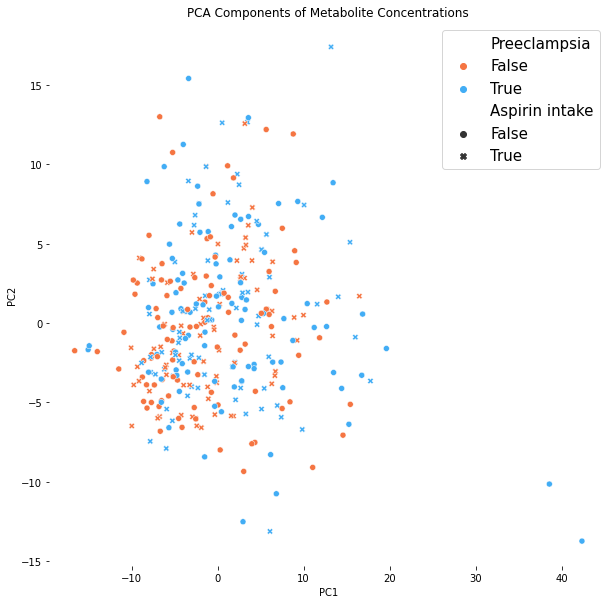

In [51]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_metabolites_pca)

# Convert PCA result to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Preeclampsia'] = clin_filt_df['pe'].astype(int).apply(lambda x: False if x==0 else True).values
pca_df['Aspirin intake'] = clin_filt_df['ASA'].values

# Plot the PCA result
plt.figure(figsize=(10, 10))

# Scatter plot with different colors based on 'pe' column
ax = sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Preeclampsia', style='Aspirin intake', palette=['#f57542', '#42adf5'])
plt.title('PCA Components of Metabolite Concentrations')
plt.legend(prop={'size': 15})
# plt.grid(True)
plt.box(False)
plt.savefig('PCA.png', dpi=300)
plt.show()

# Out data to excel

In [52]:
met_df_corr_filt_out = met_df_corr_filt.copy()
met_df_corr_filt_out.loc[:, 'ASA'] = clin_df['ASA']
met_df_corr_filt_out.loc[:, 'trimester'] = clin_df['trimester']
met_df_corr_filt_out.to_excel('no_LR_data.xlsx')